In [ ]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image
import numpy as np

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
  
    conv = BatchNormalization()(conv, training=False)
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
    skip_connection = conv    
    return next_layer, skip_connection

def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(prev_layer_input)
    merge = concatenate([up, skip_layer_input], axis=3)
    conv = Conv2D(n_filters, 
                 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3, 
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=3)

Test

In [ ]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=2)
# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
def get_sub_img(np_img, dimension_img):
    img_list = []
    x_no = np_img.shape[0]//dimension_img
    y_no = np_img.shape[1]//dimension_img
    for x_int in range(x_no):
        for y_int in range(y_no):
            sub_img = np_img[x_int*dimension_img:(x_int+1)*dimension_img,y_int*dimension_img:(y_int+1)*dimension_img,:]
            img_list.append(sub_img)
    return img_list


In [ ]:
from os import listdir
from os.path import isfile, join
# print(os.listdir())
to_segment = [f for f in listdir('Images') if isfile(join('Images', f))]
print(to_segment)
for i in range(len(to_segment)):
  to_segment[i] = "Images/"+to_segment[i]
print(to_segment)

to_train = [f for f in listdir('Training') if isfile(join('Training', f))]
print(to_train)
for i in range(len(to_train)):
  to_train[i] = "Training/"+to_train[i]
print(to_train)

masks_path = [f for f in listdir('Masks') if isfile(join('Masks', f))]
print(masks_path)
for i in range(len(masks_path)):
  masks_path[i] = "Masks/"+masks_path[i]
print(masks_path)

['lower one 50-nonpol.jpg', 'low 500x.jpg', 'lower one 50x.jpg', 'low 150x.jpg', 'lower one pol 50x.jpg']
['Images/lower one 50-nonpol.jpg', 'Images/low 500x.jpg', 'Images/lower one 50x.jpg', 'Images/low 150x.jpg', 'Images/lower one pol 50x.jpg']
['p.jpg', 'e.jpg', 'a.jpg']
['Training/p.jpg', 'Training/e.jpg', 'Training/a.jpg']
['p.jpg', 'e.jpg', 'a.jpg']
['Masks/p.jpg', 'Masks/e.jpg', 'Masks/a.jpg']


In [ ]:
# import mxnet as mx
# mean = [0, 10, 20]
# stdev = [1, 2, 3]
# aug_brightness = mx.image.BrightnessJitterAug(brightness=1)
# aug_contrast = mx.image.ContrastJitterAug(contrast=1)
# aug_saturation = mx.image.SaturationJitterAug(saturation=1)
# aug_hue = mx.image.HueJitterAug(hue=0.5)
# aug_lighting = mx.image.LightingAug(alphastd=100, eigval=np.asarray([1,1,1]), eigvec=np.ones((3,3)))
# aug_colour_normalisation = mx.image.ColorNormalizeAug(mean=mean, std=stdev)
# aug_greyscale = mx.image.RandomGrayAug(p=1)
# aug_combination = mx.image.ColorJitterAug(brightness=1, contrast=1, saturation=1)

def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)

random patches, sliding window, flip, rotate, change brightness and contrast

In [ ]:
from numpy.ma.extras import mask_cols
# import imageio.v2 as imageio
import numpy as np

# Imports PIL module 
from PIL import Image, ImageOps
import cv2
import matplotlib.pyplot as plt

# inputs = ['\\Copy of images\OM\\1-a.jpg', '\\Copy of images\OM\\1-e.png', '\\Copy of images\OM\\1-p']
# targets = ['\\Copy of images\Masks\\1-a.jpg', '\\Copy of images\Masks\\1-e.png', '\\Copy of images\Masks\\1-p']

inputs = to_train
targets = masks_path
# mu = ['images/50x left pg 4.PNG', 'images/50x right pg 4.PNG', 'images/100x left pg 4.PNG', 'images/150x right pg 4.PNG']
mu = to_segment


images1 = []
images2 = []
images3 = []
images4 = []

masks = []
mus = []

masks_1 = []


images_1 = []
images_2 = []
images_3 = []
images_4 = []

mu_images_1 = []
sub_img_list1 = []
sub_img_list2 = []
sub_img_list3 = []
sub_img_list4 = []

sub_mask_list = []

for i in range(len(inputs)):
    print(inputs[i])
    print(targets[i])

# read an image
for i in range(len(inputs)):
    img = (Image.open(inputs[i])) 
    mask = Image.open(targets[i]).convert('L') 
    mu_image = Image.open(targets[i])

    images_1.append(img)
    masks_1.append(mask)
    mu_images_1.append(mu_image)

# levels = [-50, 50, 200]
levels = [-100, 0, 100, 150]
for i in range(len(images_1)):
      images_2.append(change_contrast(images_1[i], -100))
      images_3.append(change_contrast(images_1[i], 50))
      images_4.append(change_contrast(images_1[i], 100))
        # plt.imshow(contrast_img)
        # plt.show()

for i in range(len(images_1)):
    np_img1 = np.asarray(images_1[i])
    np_img2 = np.asarray(images_2[i])
    np_img3 = np.asarray(images_3[i])
    np_img4 = np.asarray(images_4[i])

    np_mask = np.asarray(masks_1[i])
    # print(np_mask)
    # plt.imshow(np_mask)
    # plt.show() 
    np_mask = np.clip(np_mask, 254, 255)
    np_mask = np.absolute(np_mask-255*np.ones(np_mask.shape))
    # plt.imshow(np_mask)
    # plt.show() 
    kernel = np.ones((3,3),np.uint8) 
    np_mask = cv2.dilate(np_mask,kernel,iterations = 1) 	
    # plt.imshow(np_mask)
    # plt.show() 

    np_mask = np.expand_dims(np_mask, axis=-1)    
    # plt.imshow(np_mask)
    # plt.show() 

    # np_mask = cv2.cvtColor(np_mask, cv2.COLOR_BGR2GRAY)
    # img.show()
    # mask.show()

    # img = iio.imread(OM_list[i])
    # mask = iio.imread(Masks_list[i])
    images1.append(np_img1)
    images2.append(np_img2)
    images3.append(np_img3)
    images4.append(np_img4)

    masks.append(np_mask)

for i in range(len(images1)):
    add_img1 = get_sub_img(images1[i], 128)
    add_img2 = get_sub_img(images2[i], 128)
    add_img3 = get_sub_img(images3[i], 128)
    add_img4 = get_sub_img(images4[i], 128)
    add_mask = get_sub_img(masks[i], 128)

    sub_img_list1 += add_img1
    sub_img_list2 += add_img2
    sub_img_list3 += add_img3
    sub_img_list4 += add_img4
    sub_mask_list += add_mask

for i in range(len(mu)):
    # mu_image = ImageOps.grayscale(Image.open(mu[i])) 
    mu_image = Image.open(mu[i]).convert('RGB')
    mus.append(np.asarray(mu_image))
    

# write it in a new format


Training/p.jpg
Masks/p.jpg
Training/e.jpg
Masks/e.jpg
Training/a.jpg
Masks/a.jpg


In [ ]:
import cv2
import numpy as np

def contrast(img, num):
  # converting to LAB color space
  lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  l_channel, a, b = cv2.split(lab)

  # Applying CLAHE to L-channel
  # feel free to try different values for the limit and grid size:
  clahe = cv2.createCLAHE(clipLimit=num, tileGridSize=(8,8))
  cl = clahe.apply(l_channel)

  # merge the CLAHE enhanced L-channel with the a and b channel
  limg = cv2.merge((cl,a,b))

  # Converting image from LAB Color model to BGR color spcae
  enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

  # Stacking the original image with the enhanced image
  # result = np.hstack((img, enhanced_img))
  # cv2.imshow('Result', result)
  return enhanced_img

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data

def transform(image, image2):
  rows, cols = image.shape[0], image.shape[1]

  src_cols = np.linspace(0, cols, 20)
  src_rows = np.linspace(0, rows, 10)
  src_rows, src_cols = np.meshgrid(src_rows, src_cols)
  src = np.dstack([src_cols.flat, src_rows.flat])[0]

  # add sinusoidal oscillation to row coordinates
  dst_rows = src[:, 1] - np.sin(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
  dst_cols = src[:, 0]
  dst_rows *= 1.5
  dst_rows -= 1.5 * 50
  dst = np.vstack([dst_cols, dst_rows]).T


  tform = PiecewiseAffineTransform()
  tform.estimate(src, dst)

  out_rows = image.shape[0] - 1.5 * 50
  out_cols = cols
  out = warp(image, tform, output_shape=(out_rows, out_cols))
  out2 = warp(image2, tform, output_shape=(out_rows, out_cols))
  return out, out2
  # fig, ax = plt.subplots()
  # ax.imshow(out)
  # ax.plot(tform.inverse(src)[:, 0], tform.inverse(src)[:, 1], '.b')
  # ax.axis((0, out_cols, out_rows, 0))
  # plt.show()

# import mxnet as mx
# mean = [0, 10, 20]
# stdev = [1, 2, 3]
# aug_brightness = mx.image.BrightnessJitterAug(brightness=1)
# aug_contrast = mx.image.ContrastJitterAug(contrast=1)
# aug_saturation = mx.image.SaturationJitterAug(saturation=1)
# aug_hue = mx.image.HueJitterAug(hue=0.5)
# aug_lighting = mx.image.LightingAug(alphastd=100, eigval=np.asarray([1,1,1]), eigvec=np.ones((3,3)))
# aug_colour_normalisation = mx.image.ColorNormalizeAug(mean=mean, std=stdev)
# aug_greyscale = mx.image.RandomGrayAug(p=1)
# aug_combination = mx.image.ColorJitterAug(brightness=1, contrast=1, saturation=1)

In [ ]:
# import mxnet as mx 
def augment(the_list):
  for i in range(len(the_list)):
    # print(i)
    # temp_img = mx.nd.array(sub_img_list[i])
    the_list.append(np.fliplr(the_list[i]))
    the_list.append(np.flipud(the_list[i]))
    the_list.append(contrast(the_list[i], 2.0))
    the_list.append(contrast(the_list[i], 1.0))
    the_list.append(contrast(the_list[i], 3.0))
  return the_list

def augment_mask(the_list):
  for i in range(len(the_list)):
    # print(i)
    # temp_img = mx.nd.array(sub_img_list[i])
    the_list.append(np.fliplr(the_list[i]))
    the_list.append(np.flipud(the_list[i]))
    the_list.append(the_list[i])
    the_list.append(the_list[i])
    the_list.append(the_list[i])
  return the_list

# for i in range(len(sub_img_list1)):
#   # print(i)
#   # temp_img = mx.nd.array(sub_img_list[i])
#   sub_img_list1.append(np.fliplr(sub_img_list1[i]))
#   sub_mask_list.append(np.fliplr(sub_mask_list[i]))
#   sub_img_list1.append(np.flipud(sub_img_list1[i]))
#   sub_mask_list.append(np.flipud(sub_mask_list1[i]))
#   sub_img_list1.append(contrast(sub_img_list1[i], 2.0))
#   sub_mask_list.append(sub_mask_list[i])
#   sub_img_list1.append(contrast(sub_img_list1[i], 1.0))
#   sub_mask_list.append(sub_mask_list[i])
#   sub_img_list1.append(contrast(sub_img_list1[i], 3.0))
#   sub_mask_list.append(sub_mask_list[i])
def multiply(the_list, multiple):
    length = len(the_list)
    for i in range(multiple):
        for j in range(length):
            the_list.append(the_list[j])
    return the_list

sub_img_list1 = augment(sub_img_list1)
sub_img_list2 = augment(sub_img_list2)
sub_img_list3 = augment(sub_img_list3)
sub_img_list4 = augment(sub_img_list4)
sub_mask_list = augment_mask(sub_mask_list)



  # sub_mask_list.append(np.asarray(aug_contrast(temp_img)))
  # sub_mask_list.append(sub_mask_list[i])
  # sub_mask_list.append(np.asarray(aug_brightness(temp_img)))
  # sub_mask_list.append(sub_mask_list[i])
  # sub_mask_list.append(np.asarray(aug_saturation(temp_img)))
  # sub_mask_list.append(sub_mask_list[i])
  # sub_mask_list.append(np.asarray(aug_hue(temp_img)))
  # sub_mask_list.append(sub_mask_list[i])
  # sub_mask_list.append(np.asarray(aug_lighting(temp_img)))
  # sub_mask_list.append(sub_mask_list[i])
  # sub_mask_list.append(np.asarray(aug_colour_normalisation(temp_img)))
  # sub_mask_list.append(sub_mask_list[i])
  # sub_mask_list.append(np.asarray(aug_greyscale(temp_img)))
  # sub_mask_list.append(sub_mask_list[i])
  # sub_mask_list.append(np.asarray(aug_combination(temp_img)))
  # sub_mask_list.append(sub_mask_list[i])

  # image1, image2 = transform(sub_img_list[i], sub_mask_list[i])
  # print(image1.shape)
  # sub_img_list.append(image1)
  # sub_mask_list.append(image2)

# for i in range(len(sub_img_list)):
#   # print(i)
#   sub_img_list.append(contrast(sub_img_list[i]))
#   sub_mask_list.append(sub_mask_list[i])
  # image1, image2 = transform(sub_img_list[i], sub_mask_list[i])
  # sub_img_list.append(image1)
  # sub_mask_list.append(image2)

In [ ]:
print(len(sub_img_list1), len(sub_mask_list))

3096 3096


In [ ]:
# images = []
# masks = []
# # mus = []
# images_1 = []
# masks_1 = []
# mu_images_1 = []
# # sub_img_list = []
# # sub_mask_list = []

In [ ]:
# for i in range(len(sub_img_list)):  
#   sub_img_list.append(contrast(sub_img_list[i], 1.0))
#   sub_mask_list.append(sub_mask_list[i])
#   sub_img_list.append(contrast(sub_img_list[i], 3.0))
#   sub_mask_list.append(sub_mask_list[i])

In [ ]:
# import numpy as np
# from scipy.ndimage.interpolation import rotate

# x = np.random.randint(800, 1000, size=[100, 100, 3])
# rotated = rotate(x, angle=45)

In [ ]:
import math
np_sub_img_list1 = np.asarray(sub_img_list1)
np_sub_img_list2 = np.asarray(sub_img_list2)
np_sub_img_list3 = np.asarray(sub_img_list3)
np_sub_img_list4 = np.asarray(sub_img_list4)

np_sub_mask_list = np.asarray(sub_mask_list)

print(np_sub_img_list1.shape, np_sub_mask_list.shape)
# (x_train, y_train)=(np_sub_img_list, np_sub_mask_list)

#Train-validation-test split
indices = np.arange(np_sub_img_list1.shape[0])
np.random.seed(99)
np.random.shuffle(indices)
test_size = 0.1
val_size = 0.2
print(indices)
test_indices = indices[0:math.floor(0.1*(indices.shape[0]))]
train_indices = indices[math.floor(0.1*indices.shape[0])+1:indices.shape[0]]
val_indices = train_indices[0:math.floor(0.1*train_indices.shape[0])]
train_indices = train_indices[math.floor(0.1*indices.shape[0])+1:train_indices.shape[0]]
# x_test, y_test = np_sub_img_list1[test_indices], np_sub_mask_list[test_indices]
# x_val, y_val = np_sub_img_list1[val_indices], np_sub_mask_list[val_indices]
# x_train, y_train = np_sub_img_list1[train_indices], np_sub_mask_list[train_indices]


x_test = np.concatenate((np_sub_img_list1[test_indices], np_sub_img_list2[test_indices], np_sub_img_list3[test_indices], np_sub_img_list4[test_indices]), axis=0) 
y_test = np.concatenate((np_sub_mask_list[test_indices], np_sub_mask_list[test_indices], np_sub_mask_list[test_indices], np_sub_mask_list[test_indices]), axis=0) 
x_val = np.concatenate((np_sub_img_list1[val_indices], np_sub_img_list2[val_indices], np_sub_img_list3[val_indices], np_sub_img_list4[val_indices]), axis=0) 
y_val = np.concatenate((np_sub_mask_list[val_indices], np_sub_mask_list[val_indices], np_sub_mask_list[val_indices], np_sub_mask_list[val_indices]), axis=0)
x_train = np.concatenate((np_sub_img_list1[train_indices], np_sub_img_list2[train_indices], np_sub_img_list3[train_indices], np_sub_img_list4[train_indices]), axis=0) 
y_train = np.concatenate((np_sub_mask_list[train_indices], np_sub_mask_list[train_indices], np_sub_mask_list[train_indices], np_sub_mask_list[train_indices]), axis=0)


# from sklearn.model_selection import train_test_split
# x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=.1)
# x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.2)

#Dimension of the CIFAR10 dataset
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

(3096, 128, 128, 3) (3096, 128, 128, 1)
[ 429  345  544 ... 1737 1209  641]
((9904, 128, 128, 3), (9904, 128, 128, 1))
((1112, 128, 128, 3), (1112, 128, 128, 1))
((1236, 128, 128, 3), (1236, 128, 128, 1))


In [ ]:
model = unet

In [ ]:
# results = unet.fit(x_train, y_train, batch_size=20, epochs=10, validation_data=(x_val, y_val))
results = model.fit(x_train, y_train, batch_size=50, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
199/199 [==============================] - 59s 287ms/step - loss: 1.9512 - accuracy: 0.7909 - val_loss: 0.4484 - val_accuracy: 0.8455
Epoch 2/10
199/199 [==============================] - 58s 292ms/step - loss: 0.3797 - accuracy: 0.8573 - val_loss: 0.2976 - val_accuracy: 0.8802
Epoch 3/10
199/199 [==============================] - 58s 293ms/step - loss: 0.2893 - accuracy: 0.8808 - val_loss: 0.2618 - val_accuracy: 0.8890
Epoch 4/10
199/199 [==============================] - 58s 292ms/step - loss: 0.2605 - accuracy: 0.8890 - val_loss: 0.2370 - val_accuracy: 0.8989
Epoch 5/10
199/199 [==============================] - 58s 293ms/step - loss: 0.2275 - accuracy: 0.9001 - val_loss: 0.2192 - val_accuracy: 0.9043
Epoch 6/10
199/199 [==============================] - 58s 293ms/step - loss: 0.2006 - accuracy: 0.9120 - val_loss: 0.2074 - val_accuracy: 0.9151
Epoch 7/10
199/199 [==============================] - 58s 293ms/step - loss: 0.1738 - accuracy: 0.9240 - val_loss: 0.1904 - val_ac

In [ ]:
# model.save('3partly_trained3.h5')

#Load partly trained model
from keras.models import load_model
model = load_model('3partly_trained3.h5')

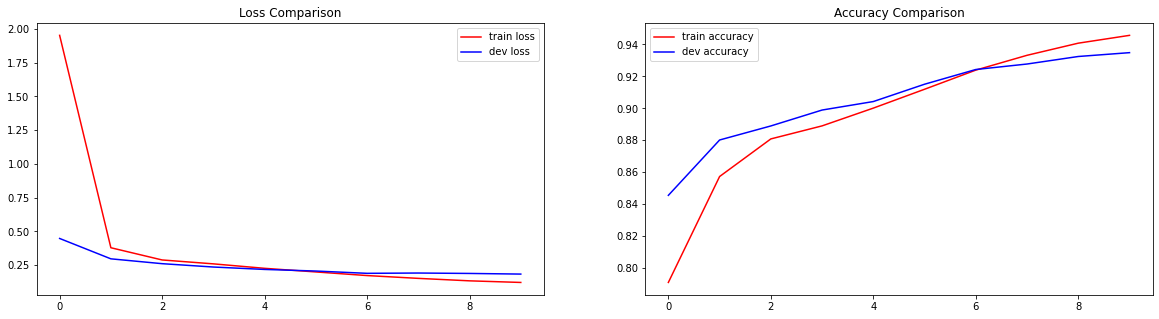

In [ ]:
# High Bias is a characteristic of an underfitted model and we would observe low accuracies for both train and validation set
# High Variance is a characterisitic of an overfitted model and we would observe high accuracy for train set and low for validation set
# To check for bias and variance plit the graphs for accuracy 
# I have plotted for loss too, this helps in confirming if the loss is decreasing with each iteration - hence, the model is optimizing fine
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

# RESULTS
# The train loss is consistently decreasing showing that Adam is able to optimize the model and find the minima
# The accuracy of train and validation is ~90% which is high enough, so low bias
# and the %s aren't that far apart, hence low variance

In [ ]:
model.evaluate(x_val, y_val)
model.evaluate(x_test, y_test)

NameError: ignored

In [ ]:
# Results of Validation Dataset
def VisualizeResults(index,x,y):
    img = x[index]
    img = img[np.newaxis, ...]
    pred_y = model.predict(img)
    print(pred_y.shape)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    print('pred_mask', pred_mask.shape)
    pred_mask = pred_mask[..., tf.newaxis]
    print('pred_mask', pred_mask.shape)

    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(x[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

(1, 128, 128, 2)
pred_mask (128, 128)
pred_mask (128, 128, 1)
(1, 128, 128, 2)
pred_mask (128, 128)
pred_mask (128, 128, 1)


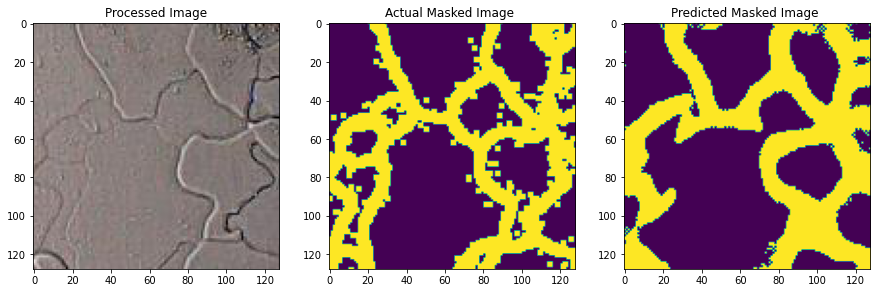

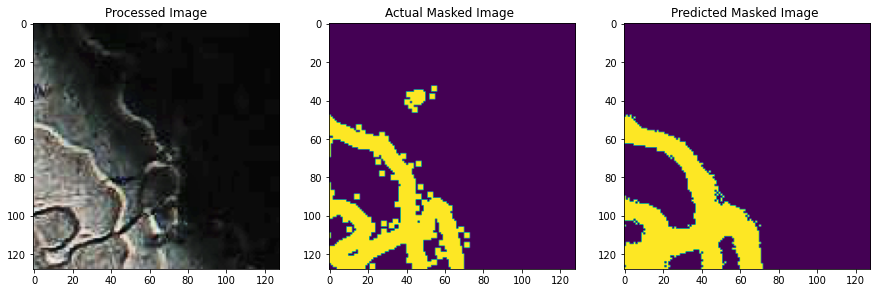

In [ ]:
# Add any index to contrast the predicted mask with actual mask
index = 60
VisualizeResults(index,x_val,y_val)
VisualizeResults(index,x_test,y_test)

In [ ]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((9904, 128, 128, 3), (9904, 128, 128, 1))
((1112, 128, 128, 3), (1112, 128, 128, 1))
((1236, 128, 128, 3), (1236, 128, 128, 1))


In [ ]:
# import imageio.v2 as imageio
import numpy as np

# Imports PIL module 
from PIL import Image, ImageOps
import cv2
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
# print(os.listdir())
onlyfiles = [f for f in listdir('Images') if isfile(join('Images', f))]
print(onlyfiles)
for i in range(len(onlyfiles)):
  onlyfiles[i] = "Images/"+onlyfiles[i]
print(onlyfiles)

# inputs = ['\\Copy of images\OM\\1-a.jpg', '\\Copy of images\OM\\1-e.png', '\\Copy of images\OM\\1-p']
# targets = ['\\Copy of images\Masks\\1-a.jpg', '\\Copy of images\Masks\\1-e.png', '\\Copy of images\Masks\\1-p']

mu = onlyfiles


images = []
masks = []
mus = []
sub_img_list = []
sub_mask_list = []

for i in range(len(mu)):
    print(mu[i])

for i in range(len(mu)):
    # mu_image = ImageOps.grayscale(Image.open(mu[i])) 
    mu_image = Image.open(mu[i]).convert('RGB')
    mus.append(np.asarray(mu_image))
    
# write it in a new format


['lower one 50-nonpol.jpg', 'lower one 50x.jpg', 'low 150x.jpg', 'lower one pol 50x.jpg', 'low 500x.jpg']
['Images/lower one 50-nonpol.jpg', 'Images/lower one 50x.jpg', 'Images/low 150x.jpg', 'Images/lower one pol 50x.jpg', 'Images/low 500x.jpg']
Images/lower one 50-nonpol.jpg
Images/lower one 50x.jpg
Images/low 150x.jpg
Images/lower one pol 50x.jpg
Images/low 500x.jpg


(1200, 1600, 3)
<class 'numpy.ndarray'>


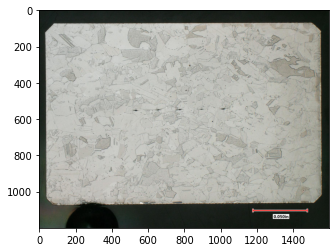

(1200, 1600, 3)
108
108
(1200, 1600, 3)
<class 'numpy.ndarray'>


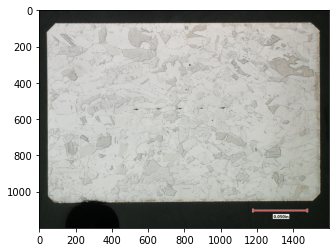

(1200, 1600, 3)
108
108
(1200, 1600, 3)
<class 'numpy.ndarray'>


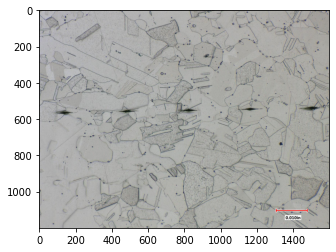

(1200, 1600, 3)
108
108
(1200, 1600, 3)
<class 'numpy.ndarray'>


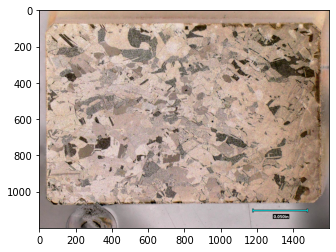

(1200, 1600, 3)
108
108
(1200, 1600, 3)
<class 'numpy.ndarray'>


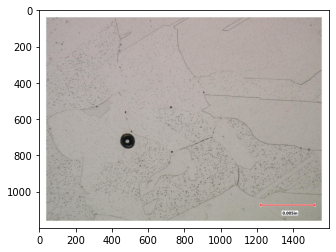

(1200, 1600, 3)
108
108


In [ ]:
import cv2

def get_new_np(np_img, dimension_img):
    count = 0
    img_list = []
    x_no = np_img.shape[0]//dimension_img
    y_no = np_img.shape[1]//dimension_img
    new_np = np.zeros((np_img.shape[0], np_img.shape[1], np_img.shape[2]-1)).astype(int)
    for x_int in range(x_no):
        for y_int in range(y_no):
            # print(new_np.shape)
            sub_img = np_img[x_int*dimension_img:(x_int+1)*dimension_img,y_int*dimension_img:(y_int+1)*dimension_img,:]
            sub_img = sub_img[np.newaxis, ...]
            # print(sub_img.shape)
            pred_y = model.predict(sub_img)

            # #check mask
            # new_np2 = np.copy(pred_y)
            # new_np2_mask = tf.argmax(new_np2[0], axis=-1)
            # new_np2_mask = new_np2_mask[..., tf.newaxis]
            # print(new_np2_mask.shape)
            # plt.imshow(new_np2_mask[:,:,0])
            # plt.show()

            # print(pred_y.shape)
            # print(sub_img.shape, new_np[x_int*dimension_img:(x_int+1)*dimension_img,y_int*dimension_img:(y_int+1)*dimension_img,:].shape)
            new_np[x_int*dimension_img:(x_int+1)*dimension_img,y_int*dimension_img:(y_int+1)*dimension_img,:] = pred_y[0]
            count += 1
    print(count)
    return new_np

def get_same_np(np_img, dimension_img):
    count = 0
    img_list = []
    x_no = np_img.shape[0]//dimension_img
    y_no = np_img.shape[1]//dimension_img
    new_np = np.zeros(np_img.shape).astype(int)
    for x_int in range(x_no):
        for y_int in range(y_no):
            # print(new_np.shape)
            sub_img = np_img[x_int*dimension_img:(x_int+1)*dimension_img,y_int*dimension_img:(y_int+1)*dimension_img,:]
            # print(sub_img.shape, new_np[x_int*dimension_img:(x_int+1)*dimension_img,y_int*dimension_img:(y_int+1)*dimension_img,:].shape)
            new_np[x_int*dimension_img:(x_int+1)*dimension_img,y_int*dimension_img:(y_int+1)*dimension_img,:] = sub_img
            # print(type(new_np[x_int*dimension_img:(x_int+1)*dimension_img,y_int*dimension_img:(y_int+1)*dimension_img,:]))
            # new_np[x_int*dimension_img:(x_int+1)*dimension_img,y_int*dimension_img:(y_int+1)*dimension_img,:] = sub_img
            # plt.imshow(new_np)
            # plt.show()
            count += 1
    print(count)
    return new_np
# new_np = get_new_np(np_img, 128)
# to_see = mus[2]
new_mus_list = []
same_mus_list = []

dark = [3]
for i in dark:
  mus[i] = cv2.bitwise_not(mus[i])

list_to_see = mus

for i in range(len(list_to_see)):
    to_see = list_to_see[i]
    print(to_see.shape)
    print(type(to_see))
    plt.imshow(to_see)
    plt.show()
    print(to_see.shape)
    same_np = get_same_np(to_see, 128) 
    new_np = get_new_np(to_see, 128)
    new_mus_list.append(new_np)
    same_mus_list.append(same_np)

(1200, 1600, 3)


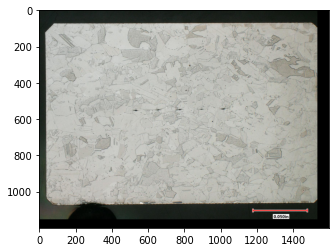

(1200, 1600, 2)
before argmax (1, 1200, 1600, 2)
after argmax (1200, 1600)
(1200, 1600, 1)


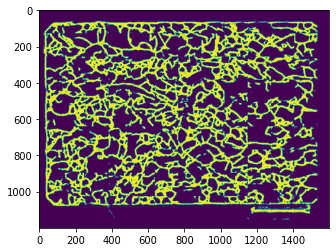

(1200, 1600)


TypeError: ignored

In [ ]:
import tensorflow as tf

from PIL import Image

for i in range(len(same_mus_list)): 
    same_np2 = np.copy(same_mus_list[i])
    # new_np2 = new_np2[np.newaxis, ...]
    # new_np2_mask = tf.argmax(new_np2[0], axis=-1)
    # new_np2_mask = new_np2_mask[..., tf.newaxis]
    # # plt.title('Actual Masked Image ')
    print(same_np2.shape)
    plt.imshow(same_np2)
    plt.show()


    new_np2 = np.copy(new_mus_list[i])
    print(new_np2.shape)

    new_np2 = new_np2[np.newaxis, ...]
    print('before argmax', new_np2.shape)
    # print(new_np2)
    new_np2_mask = tf.argmax(new_np2[0], axis=-1)
    print('after argmax', new_np2_mask.shape)
    new_np2_mask = new_np2_mask[..., tf.newaxis]
    # plt.title('Actual Masked Image ')
    print(new_np2_mask.shape)
    plt.imshow(new_np2_mask[:,:,0])
    plt.show()
    print(np.asarray(new_np2_mask)[:,:,0].shape)

    im = Image.fromarray(np.asarray(np.squeeze(new_np2_mask,-1)))
    im.save(str(i)+".jpeg") 


    # im = Image.fromarray(new_np2)
    # im.save("your_file.jpeg")


# plt.imshow(new_np)
# plt.show()

In [ ]:
np.squeeze(new_np2_mask, -1).shape

(1200, 1600)